## This script computes the static and dynamic properties of clusters that can be mapped to its fusion bahavior

In [37]:
import re, sys, os  
import numpy as np 
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from numpy import *  
from time import time 
import networkx as nx 
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from glob import glob 
from scipy.spatial.distance import cdist


def ProgressBar(jobName, progress, length=40):
    completionIndex = round(progress*length)
    msg = "\r{} : [{}] {}%".format(jobName, "*"*completionIndex + "-"*(length-completionIndex), round(progress*100))
    if progress >= 1: msg += "\r\n"
    sys.stdout.write(msg)
    sys.stdout.flush()

def calc_RadGy(posList):
    # posList = N,3 array for N sites
    com = np.mean(posList, axis=0) # center of mass
    Rg2 = np.mean(np.sum((posList - com)**2, axis=1))
    return com, np.sqrt(Rg2) 

def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

def readFile(file):
    with open(file,'r') as tf:
        lines = tf.readlines()
    return lines 

def getBlock(lines, str1='', str2='', skipName=True):
    # skipName => whether to return heading  
    i1, i2 = 0, 0
    for i, line in enumerate(lines):
        if re.search(str1, line):
            i1 = i 
        if re.search(str2, line):
            i2 = i 
    if str2 == '':
        i2 = len(lines)
        
    if skipName:
        return lines[i1+1:i2]
    else:
        return lines[i1:i2]
    
def processCoorBlock(cBlock):
    tmp_frame = array([line.strip().split() for line in cBlock[1:-1]])
    atomId = tmp_frame[:,0].astype(np.int32)
    atomTyp = tmp_frame[:,2].astype(np.int32)
    charge = tmp_frame[:,3].astype(np.float32)
    mId = tmp_frame[:,1].astype(np.int32)
    pos = tmp_frame[:,[4,5,6]].astype(np.float32)
    return atomId, mId, atomTyp, charge, pos

def processBondBlock(bBlock):
    tmp_frame = array([line.strip().split() for line in bBlock[1:-1]])
    bId = tmp_frame[:,0].astype(np.int32)
    bTyp = tmp_frame[:,1].astype(np.int32)
    bPair = tmp_frame[:,[-2,-1]].astype(np.int32)
    return bId, bTyp, bPair 


def parseDataFile(dfile):
    lines = readFile(dfile)
    coor_block = getBlock(lines, 'Atoms', 'Velocities')
    bond_block = getBlock(lines, 'Bonds', 'Angles')
    
    atomId, mId, atomTyp, charge, pos = processCoorBlock(coor_block)
    _, _, aPair = processBondBlock(bond_block)
    a2m = dict(zip(atomId, mId))
    mBonds = [(a2m[a1], a2m[a2]) for a1,a2 in aPair if a2m[a1] != a2m[a2]]
    
    return mBonds, atomId, mId, pos, aPair, atomTyp  

def getMolecularLocation(G, aID, mID, posArr):
    
    nodes = G.nodes()
    clus_com, clus_Rg = calc_RadGy(posArr)
    hull = ConvexHull(posArr)
    
    dist_stat = {} # distance of molecules from cluster center of mass
    for i, mol in enumerate(nodes):
        idx = np.where(mID == mol)
        com = mean(posArr[idx], axis=0)
        dist = sqrt(np.sum((com - clus_com)**2))
        dist_stat[mol] = dist
    
    return dist_stat, clus_Rg, hull.area 

def getGeodesicLength(G):
    test_node = list(G.nodes())[0]
    geo_dist_dict = nx.shortest_path_length(G, test_node) # source node : test_node, target: all other nodes 
    gdst = list(geo_dist_dict.values())
    return mean(array(gdst))

def getSpatialTopology(dfile, valency=5):
    GList = [] # GList: GeoDesic Length 
    mBonds, aId, mId, pos, bonds, _ = parseDataFile(dfile)
    G = nx.Graph()
    G.add_edges_from(bonds)
    for g in connected_component_subgraphs(G):
        if len(g.nodes) < 250:
            pass 
        else:
            GList.append(getGeodesicLength(g))
    
    mG = nx.MultiGraph()
    mG.add_edges_from(mBonds)
    
    satList, distList, RgList, HAList = [], [], [], []
    
    for g in connected_component_subgraphs(mG):
        if len(g.nodes) < 10:
            pass 
        else:
            #print(len(g.nodes))
            mol_dist, Rg, hA = getMolecularLocation(g, aId, mId, pos)
            satList.extend([(mG.degree(mol))/valency for mol in mol_dist.keys()])
            distList.extend(mol_dist.values())
            RgList.append(Rg)
            HAList.append(hA)
            
            
    return satList, distList, RgList, HAList, GList

def getStickerLocation(dfile):
    mBonds, aId, mId, pos, bonds, aTyp = parseDataFile(dfile)
    sticker_idx = [i for i, a in enumerate(aTyp) if (a==1) or (a==3)]
    spacer_idx = [i for i, a in enumerate(aTyp) if (a==2) or (a==4)]
    #spacers_idx = np.where((aId==2) or (aId==4))
    com, Rg = calc_RadGy(pos)
    
    dist_stickers = cdist(array([com]), pos[sticker_idx], metric='euclidean')
    dist_spacers = cdist(array([com]), pos[spacer_idx], metric='euclidean')
    
    return dist_stickers[0], dist_spacers[0]

def getEventCount(path):
    files = glob(path + '/BondData_*.dat')
    onCount, offCount = [], []
    for file in files:
        data = np.loadtxt(file)
        onCount.extend(np.diff(data[:,1]))
        offCount.extend(np.diff(data[:,2]))
    
    np.savetxt(path + '/00_KineticEvents.txt', array([onCount, offCount]).T, 
               fmt='%.3e', header='Binding\tUnbinding')

    
def getClusterGenotypes(path):
    print(f'\npath: {path}\n')
    
    dfiles = glob(path + '/Run*.DATA')
    
    satList, distList, RgList, HAList, GList = [], [], [], [], []
    N_elem = len(dfiles)
    sticker_dist, spacer_dist = [], []
    
    for i,dfile in enumerate(dfiles):
        s,d,r,hA, GL = getSpatialTopology(dfile, valency=5)
        satList.extend(s)
        distList.extend(d)
        RgList.extend(r)
        HAList.extend(hA)
        GList.extend(GL)
        
        s1, s2 = getStickerLocation(dfile)
        sticker_dist.extend(s1)
        spacer_dist.extend(s2)
        
        
        ProgressBar("Topology_calc Progress", (i+1)/N_elem)
    
    
    np.savetxt(path + '/00_Spatial_saturation.txt', array([distList, satList]).T, fmt='%.4e', 
               header='Dist_from_COM\tSticker_Saturation')
    
    np.savetxt(path + '/00_Sphericity.txt', array([RgList, HAList, GList]).T, fmt='%.4e', 
               header='RadGy\tHullArea\tGeodesicLength')
    
    np.savetxt(path + '/00_sticker_location.txt', array(sticker_dist), fmt='%.4e')
    np.savetxt(path + '/00_spacer_location.txt', array(spacer_dist), fmt='%.4e')

path1 = './ClusterProperty/Relax_Es_3kT_Ens_03kT_input'
path2 = './ClusterProperty/Relax_Es_3kT_Ens_05kT_input'
path3 = './ClusterProperty/Relax_Es_5kT_Ens_03kT_input'
path4 = './ClusterProperty/Relax_Es_5kT_Ens_05kT_input'


for path in [path1, path2, path3, path4]:
    # Genotype means causal biophysical properties that dictate the fusion behavior (phenotype)
    getClusterGenotypes(path)
    
    # get the rate of inter-sticker bond dissociations
    getEventCount(path)




path: ./ClusterProperty/Relax_Es_3kT_Ens_03kT_input

Topology_calc Progress : [****************************************] 100%

path: ./ClusterProperty/Relax_Es_3kT_Ens_05kT_input

Topology_calc Progress : [****************************************] 100%

path: ./ClusterProperty/Relax_Es_5kT_Ens_03kT_input

Topology_calc Progress : [****************************************] 100%

path: ./ClusterProperty/Relax_Es_5kT_Ens_05kT_input

Topology_calc Progress : [****************************************] 100%


## Visualization of the cluster property 
#### C1: Es, Ens = 3kT, 0.3kT
#### C2: Es, Ens = 3kT, 0.5kT
#### C3: Es, Ens = 5kT, 0.3kT
#### C4: Es, Ens = 5kT, 0.5kT

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import mean, array, pi  
from seaborn import kdeplot 
import re
import pandas as pd  
from glob import glob 
from scipy.stats import gaussian_kde

def plotSaturationGradient(x, y, Rg, fs=14, title=''):
    plt.subplots(figsize=(4.8,4))
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    plt.scatter(x/mean(Rg), y, c=z)
    plt.ylabel('Fraction of sticker occupied', fontsize=fs, fontweight='bold')
    plt.xlabel('Radial location of molecules (R / R$_g$) ', fontsize=fs)
    #plt.title(self.labels[i])
    plt.axvline(1, ls='dotted', c='k', lw=2)
    plt.ylim(0,1.1)
    plt.xlim(-0.1,2.5)
    plt.title(title, pad=12)
    plt.tight_layout()
    #plt.show()
    
def drawBoxPlot(data, ylabel='', fs=16, labels=[], ylim=None, logScale=False):
    if logScale:
        fig, ax = plt.subplots(figsize=(4.4,3.6))
        logData = []
        for dat in data:
            logData.append(np.log10(array(dat)))
            
        green_diamond = dict(markerfacecolor='grey', marker='o')
        ax.boxplot(logData, medianprops=dict(color='b'), flierprops=green_diamond)
        ax.set_ylabel(ylabel, fontsize=fs, fontweight='bold')
        ax.set_yticks([1,2,3,4], labels=['$10$','10$^2$', '10$^3$', '10$^4$'])
        ax.set_xticks([i for i in range(1, len(labels)+1)], labels=labels)
        mycolors =['g','g','r','r']
        for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), mycolors):
            ticklabel.set_color(tickcolor)
        
    else:
        fig, ax = plt.subplots(figsize=(4.4,3.6))
        
        green_diamond = dict(markerfacecolor='grey', marker='o')
        
        ax.boxplot(data, medianprops=dict(color='b'), flierprops=green_diamond)
        
        ax.set_ylabel(ylabel, fontsize=fs, fontweight='bold')
        
        ax.set_xticks([i for i in range(1, len(labels)+1)], labels=labels)
        
        mycolors =['g','g','r','r']
        
        for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), mycolors):
            ticklabel.set_color(tickcolor)
        
        #plt.xlabel.set_color('r')
        
    if ylim != None:
        plt.ylim(ylim)
    plt.tight_layout()
    

def parseData(path):
    d1 = np.loadtxt(path + '/00_Spatial_saturation.txt')
    d2 = np.loadtxt(path + '/00_Sphericity.txt')
    
    m_Rg, m_HA = mean(d2[:,0]), mean(d2[:,1])
    
    return d1[:,0], d1[:,1], d2[:,0], d2[:,1] 

def getSaturationData(path):
    d1 = np.loadtxt(path + '/00_Spatial_saturation.txt')
    d2 = np.loadtxt(path + '/00_Sphericity.txt')
    
    m_Rg, m_HA = mean(d2[:,0]), mean(d2[:,1])
    
    idx = np.where(d1[:,1] == 1) # saturation is 1 
    dist_full = d1[:,0][idx]
    
    return dist_full/m_Rg  

def getDensity(path):
    _, _, Rg, _ = parseData(path)
    vol = (4/3)*pi* (Rg/10)**3 
    return 5000/vol 

def getBF(path):
    d = np.loadtxt(path + '/00_BondCount_average.txt')
    bf = d/500
    return bf  

def getGL(path):
    d = np.loadtxt(path + '/00_Sphericity.txt')
    return d[:,-1]

def getSphericity(path):
    d = np.loadtxt(path + '/00_Sphericity.txt')
    area, Rg = d[:,1], d[:,0]
    return 4*pi*Rg**2 / area

def getEvents(path):
    d = np.loadtxt(path + '/00_KineticEvents.txt')
    return d[:,1]
    

p1 = './ClusterProperty/Relax_Es_3kT_Ens_03kT_input'
p2 = './ClusterProperty/Relax_Es_3kT_Ens_05kT_input'
p3 = './ClusterProperty/Relax_Es_5kT_Ens_03kT_input'
p4 = './ClusterProperty/Relax_Es_5kT_Ens_05kT_input'

labels = ['C1', 'C2', 'C3', 'C4']

### Density of clusters

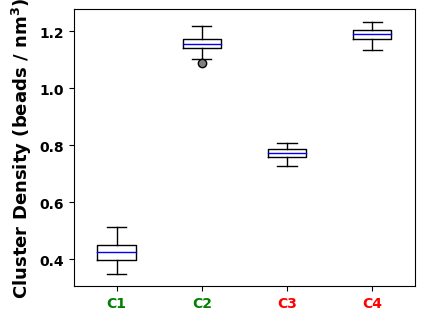

In [19]:
data_density = [getDensity(p1), getDensity(p2), getDensity(p3), getDensity(p4)]
drawBoxPlot(data_density, labels=labels, ylabel='Cluster Density (beads / nm$^3$)', fs=13)

### Degree of sticker saturation 

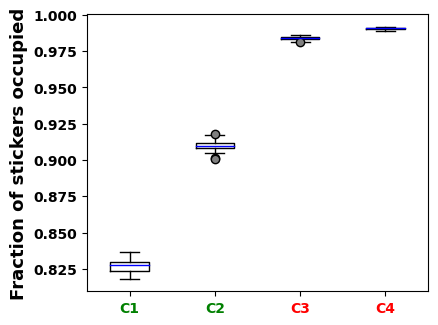

In [21]:
data_bf = [getBF(p1), getBF(p2), getBF(p3), getBF(p4)]
drawBoxPlot(data_bf, labels=labels, ylabel='Fraction of stickers occupied', fs=13)

### Distribution of shortest path (geodesic) length

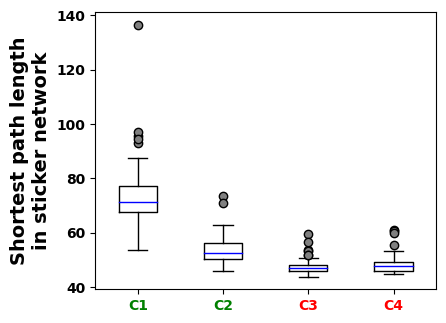

In [23]:
data_GL = [getGL(p1), getGL(p2), getGL(p3), getGL(p4)]
drawBoxPlot(data_GL, labels=labels, ylabel='Shortest path length\nin sticker network', fs=14)

### Number of dissociation events (rate of bond breakge)

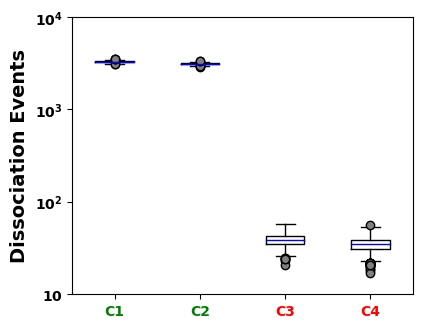

In [24]:
data_events = [getEvents(p1), getEvents(p2), getEvents(p3), getEvents(p4) ]

drawBoxPlot(data_events, labels=labels, ylabel='Dissociation Events', fs=14, logScale=True)

### Spatial distribution of sticker saturation - how sticker saturation varies along the cluster radius 

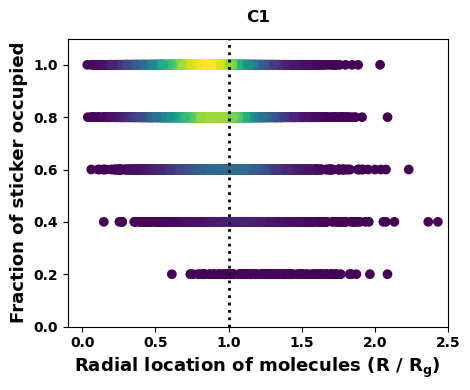

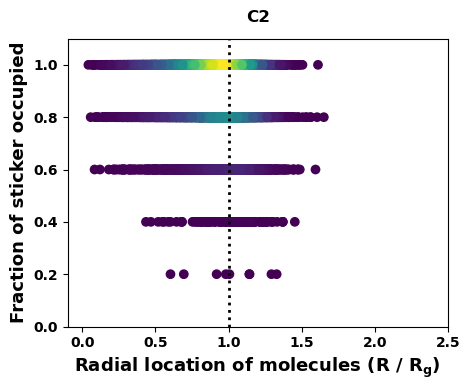

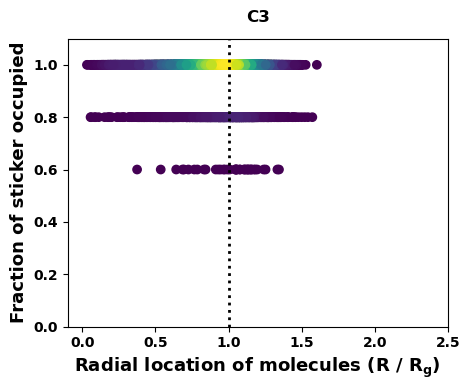

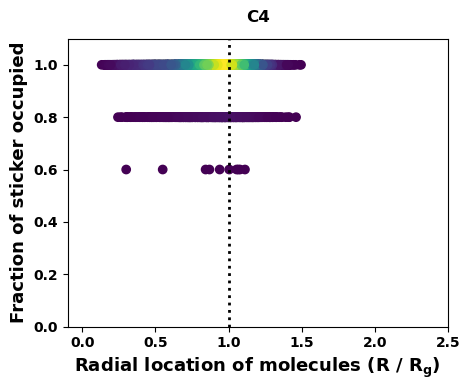

In [30]:
for i,p in enumerate([p1,p2,p3,p4]):
    dist, sat, Rg, HA = parseData(p)
    plotSaturationGradient(dist, sat, Rg, fs=13, title=labels[i])
    plt.show()

### Radial location of the fully-saturated stickers

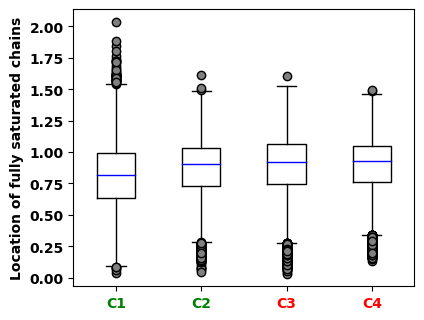

In [36]:
data_sat = [getSaturationData(p1), getSaturationData(p2), getSaturationData(p3), getSaturationData(p4)]
drawBoxPlot(data_sat, labels=labels, ylabel='Location of fully saturated chains', fs=10)